In [1]:
from __future__ import print_function, division
import datetime
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.utils import save_image
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import cv2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses

NUMBER_OF_CLASSES = len(os.listdir("RMFD/"))
print("No of classes ",NUMBER_OF_CLASSES)

No of classes  2


In [2]:
#sam 
from sam.sam import SAM

In [37]:
class_names = []

dataSamples = 2203


def dataLoc():
    x = []
    y = []
    global class_names
    class_names = os.listdir("RMFD/")
    class_names.sort()
    for label,i in enumerate(class_names):
#         class_names.append(i)
        for j in os.listdir("RMFD/"+i):
#             if i == "unmasked":
#                 dataSamples = 4406
#             else:
#                 dataSamples = 2203
            for k in os.listdir("RMFD/"+i+"/"+j):
                
                x.append("RMFD/"+i+"/"+j+"/"+k)
                y.append(label)
                if len(x)%dataSamples == 0:
                    break
            if len(x)%dataSamples == 0:
                    break
#         print(len(x[0]))

    class_count = {}
#     print(len(y))
    for index in y:
        if index not in class_count:
            class_count[index] = 0
        class_count[index] += 1
    print(class_count)
    
    x_train , x_val , y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
#     print(x_train[1],y_train[1])
#     print(class_names)
    return x_train , x_val , y_train , y_val


In [38]:
a,b,c,d = dataLoc()
# print(len(a))

{0: 2203, 1: 2203}


In [39]:



    

class ThreadDataset(Dataset):
    def __init__(self,typ,x,y):
        self.samples = []
        for j in range(len(x)):
            im_bgr = cv2.imread(x[j])
            im_rgb = im_bgr[:, :, ::-1]
            self.samples.append((im_rgb,y[j],x[j]))
#                 print(im_rgb.shape)
        if typ == "train":
            self.data_transforms = Compose([
#                 RandomResizedCrop(100, 100),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
#                 CoarseDropout(p=0.5),
#                 Cutout(p=0.5),
                ToTensorV2(p=1.0),
            ])
        else:
            self.data_transforms = Compose([
                Resize(100, 100),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ])
#         self.data_transforms = transforms.Compose([
#                 transforms.ToPILImage(),
#                 transforms.Resize(100,),
#                 transforms.RandomHorizontalFlip(),
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#             ])
        
        
        
        
    def __getitem__(self, index):
        
        image = self.samples[index][0]
        image = cv2.resize(image,(100,100))
        image = self.data_transforms(image = image)["image"]
        
        return (image,self.samples[index][1],self.samples[index][2])

    def __len__(self):
        return len(self.samples)


x_train , x_val , y_train, y_val  =  dataLoc()
threadtrainDataset = ThreadDataset("train",x_train,y_train)
threadvalDataset = ThreadDataset("val",x_val,y_val)

# threadtrainDataset,threadvalDataset = torch.utils.data.random_split(threadtrainDataset, [int(0.8*len(threadtrainDataset)),int(0.2*len(threadtrainDataset))])
# threadvalDataset = ThreadDataset("val")

{0: 2203, 1: 2203}


In [40]:
dataloaders = {"train":torch.utils.data.DataLoader(threadtrainDataset, batch_size=4,
                                             shuffle=True, num_workers=8),
               "val":torch.utils.data.DataLoader(threadvalDataset, batch_size=4,
                                             shuffle=True, num_workers=8)
              }

dataset_sizes = {"train":len(threadtrainDataset), "val":len(threadvalDataset) }

# print(dataloaders)
# class_names = ["c","t"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<class 'torch.Tensor'>


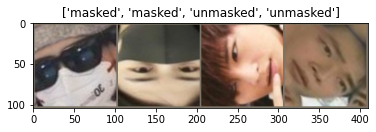

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes,path = next(iter(dataloaders['train']))
print(type(classes))
# # Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        logs = {}
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for (inputs, labels,paths) in dataloaders[phase]:
#                 print("length of data",inputs.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 
                
            prefix = ''
            if phase == 'val':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
            
#             if epoch_acc >= 1 and phase == 'val' and loss <= 0.0001:
#                 print("Training Ended")
#                 model.load_state_dict(best_model_wts)
#                 return model
                
        liveloss.update(logs)
        liveloss.send()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [43]:
def train_model_with_sam(model, criterion, optimizer, scheduler, num_epochs=25):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()
#     since = time.time()
    liveloss = PlotLosses()
    
    for epoch in range(num_epochs):
        logs = {}
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for (inputs, labels,paths) in dataloaders[phase]:
#                 print("length of data",inputs.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
#                         optimizer.step()

                        def closure():
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            return loss
                
                        optimizer.step(closure)
                    
                

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            
            prefix = ''
            if phase == 'val':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
            
            
        liveloss.update(logs)
        liveloss.send()    
        print()
            
            
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
        

In [44]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels,paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            print(datetime.datetime.now())
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(datetime.datetime.now())
            print(preds)
#             if 1 not in preds:
#                 continue
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [45]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, NUMBER_OF_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

#sam
base_optimizer = optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer_ft = SAM(model_ft.parameters(), base_optimizer, lr=0.001, momentum=0.9)



# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

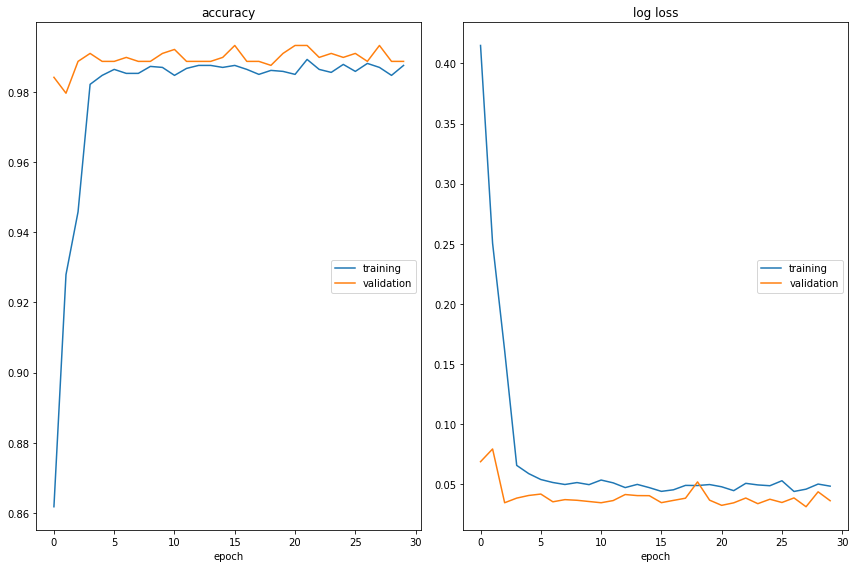

accuracy
	training         	 (min:    0.862, max:    0.989, cur:    0.988)
	validation       	 (min:    0.980, max:    0.993, cur:    0.989)
log loss
	training         	 (min:    0.044, max:    0.415, cur:    0.048)
	validation       	 (min:    0.031, max:    0.079, cur:    0.036)

Training complete in 22m 18s
Best val Acc: 0.993197


In [46]:
# callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
# model_ft.set_callbacks(callbacks)
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=10)

model_ft = train_model_with_sam(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

2021-04-20 17:23:52.787321
2021-04-20 17:23:52.793910
tensor([0, 1, 0, 0], device='cuda:0')


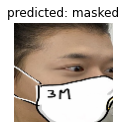

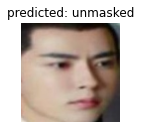

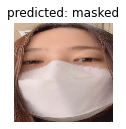

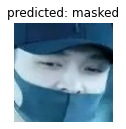

In [47]:
import datetime

# model_ft = model_ft.to("cpu")

visualize_model(model_ft,4)

plt.ioff()
plt.show()

In [48]:
import time
groundTruth = []
prediction = []
device= "cpu"
was_training = model_ft.training
model_ft = model_ft.to(device)
model_ft.eval()
# print(model_ft.training)
with torch.no_grad():
    for i, (inputs, labels,paths) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
#         print(paths)
#         print(time.time())
    

        outputs = model_ft(inputs)

    

        _, preds = torch.max(outputs, 1)
        
#         for i in preds:
#             print(class_names[i])

#         print(time.time())

        for i,val in enumerate(preds):
            if val != labels[i]:
                ima = cv2.imread(paths[i])
                cv2.imwrite("./dataset/ana/-"+str(labels[i])+"-"+str(val)+str(time.time())+".jpg",ima)
        prediction.extend(preds.cpu().numpy())
        groundTruth.extend(labels.cpu().numpy())
    
model_ft.train(mode = True)
print("done------------>")

done------------>


In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix(groundTruth, prediction)

array([[451,   6],
       [  0, 425]])

In [50]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
print("precision",precision_score(groundTruth, prediction,average='micro'))
print("recall",recall_score(groundTruth, prediction,average='micro'))
print("f1 score",f1_score(groundTruth, prediction,average='micro'))

precision 0.9931972789115646
recall 0.9931972789115646
f1 score 0.9931972789115646


In [51]:
for i,name in enumerate(class_names):
    print(i," ",name)
print(class_names)

0   masked
1   unmasked
['masked', 'unmasked']


In [53]:
#saving the model
torch.save(model_ft.state_dict(),"../mask"+str(NUMBER_OF_CLASSES)+".pth")

In [8]:
model_ft = models.resnet18(pretrained = False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 41)
model_ft.load_state_dict(torch.load("../conetip_"+str(NUMBER_OF_CLASSES)+"_.pth"))
model_ft = model_ft.to("cuda")

In [ ]:
['flight_pink', 'cb_black', 'dots_orange', 'dots_grey', 'club_blue', 'cross_green', 'cb_blue', 'dots_green', 'elephant_blue', 'dots_red']